# Adversarial examples
This notebook is inspired by the neural-nets-are-weird notebook found in [this](https://github.com/jvns/neural-nets-are-weird) github repo.

## First, we need to set up the network, preprocessing and get some data
We with some imports and basic settings

In [1]:
import numpy as np
import matplotlib.pyplot as ppt
import caffe

%matplotlib inline
caffe.set_mode_cpu()

caffe_root = '/home/chrisbot/Projects/caffe'
data_root = '/home/chrisbot/Projects/adversarial-examples/images'

We load the labels for the network

In [2]:
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    imagenet_labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except IOError: # If the data is not found, let this caffe script download it
    !{caffe_root}/data/ilsvrc12/get_ilsvrc_aux.sh
    imagenet_labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

for index, l in enumerate(imagenet_labels):
    imagenet_labels[index] = l[10:].split(',')[0]

Next, we define a function to load the network and a transformer that will bring our images to the correct format

In [3]:
BATCH_SIZE = 1 # how many images to process at once

def load_model():
    net = caffe.Net(caffe_root + '/models/bvlc_googlenet/deploy.prototxt',
                    caffe_root + '/models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape()
    return net

net = load_model()

transformer = caffe.io.Transformer( {'data': net.blobs['data'].data.shape} )
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255) # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0)) # the reference model has channels in BGR order instead of RGB

Some more auxiliary functions

In [4]:
def display(image, preds=[], probs=[], prediction_count=5):
    image_deprocessed = transformer.deprocess('data', image)
    ppt.imshow(image_deprocessed)
    
    try:
        # Set image title with most likely prediction
        label = imagenet_labels[preds[0]]
        probability = probs[preds[0]]
        ppt.title( '{0}: {1}% certainty'.format(label, round(probability*100, 2)) )

        # print the remaining predictions to stdout
        for ind, p in enumerate(preds):
            if ind > prediction_count:
                break
            label = imagenet_labels[p]
            probability = probs[p]
            print( '{0}: {1}% certainty'.format(label, round(probability*100, 2)) )
    except IndexError:
        pass # there were no predictions for this image
    
    ppt.show()

def predict(image):
    net.blobs['data'].data[...] = image
    probabilities = net.forward()['prob'][0]
    predictions = probabilities.argsort()[::-1]
    
    return predictions, probabilities

We are gonna need data for this

In [5]:
data_filenames = ['cat.jpg', 'dog.jpg', 'fence.jpg', 'kitten.jpg', 'panda.jpg', 'queen.jpg', 'sword.jpg', 'vulture.jpg']

data = {}
for df in data_filenames:
    image = caffe.io.load_image(data_root + '/' + df)
    data[df] = transformer.preprocess('data', image)

To test all this, we can let the network predict on this data

In [ ]:
for d in data.keys():
    preds, probs = predict(data[d])
    display(data[d], preds, probs)

## Turning a panda into a vulture
Now that we got our network up and running, it is time to turn a panda into a vulture! First of all, we check what the network thinks of the unaltered panda.

giant panda: 99.23% certainty
teddy: 0.16% certainty
lesser panda: 0.12% certainty
weasel: 0.06% certainty
Madagascar cat: 0.05% certainty
badger: 0.04% certainty


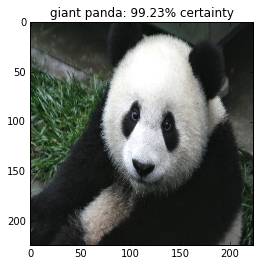

388


In [6]:
preds, probs = predict(data['panda.jpg'])
display(data['panda.jpg'], preds, probs)
print(preds[0])

Ok, so the network is quite sure that this image shows a panda. Now we need to make it more like a vulture in a subtle way. To do this, we compute the gradient of the loss function w.r.t. the input image.

$$ \nabla L = \frac{d}{d \ \text{image}} \ L(\text{pred}, \text{label}) $$

The loss depends on two components, the prediction $\text{pred}$ of the network and the $\text{label}$ for a given input. We are going to use a **false label**, e.g. a vulture label when running the network on an image of a panda. This way, backpropagation will compute a gradient for the image that changes it such that the network thinks it is a vulture.

$$ \text{image}' = \text{image} + \nabla L $$

First, we are gonna look at the gradient.

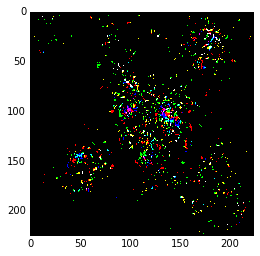

In [7]:
def compute_gradient(image, intended_outcome):
    _, _ = predict(image)
    probs = np.zeros_like(net.blobs['prob'].data)
    probs[0][intended_outcome] = 1
    
    gradient = net.backward(prob=probs, diffs=['data'])
    return gradient['data'].copy()

panda_label = 388
vulture_label = 23
cat_label = 282
gradient = compute_gradient(data['panda.jpg'], vulture_label)
display(gradient / np.percentile(gradient, 98))

That doesn't look much like a vulture, but the network considers these the relevant parts that are needed to turn a panda into a vulture. So let's do it.

vulture: 96.96% certainty
ostrich: 0.57% certainty
gibbon: 0.47% certainty
albatross: 0.37% certainty
Madagascar cat: 0.32% certainty
indri: 0.14% certainty


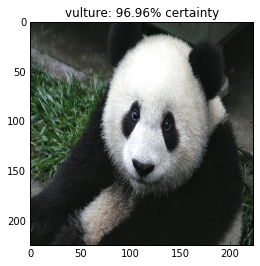

In [8]:
def turn_into(image, desired_label, iterations):
    changed_image = image.copy()
    
    pred_history, prob_history = predict(changed_image)
    for _ in range(iterations):
        gradient = compute_gradient(changed_image, desired_label)
        changed_image = changed_image + (0.9 / iterations) * np.sign(gradient)
        
        preds, probs = predict(changed_image)
        pred_history = np.vstack([pred_history, preds])
        prob_history = np.vstack([prob_history, probs])
    
    return changed_image, pred_history, prob_history

pseudo_vulture, pred_history, prob_history = turn_into(data['panda.jpg'], vulture_label, 10)
pseudo_vulture = pseudo_vulture[0,...]

preds, probs = predict(pseudo_vulture)
display(pseudo_vulture, preds, probs)

The *turn_into* function keeps a record of the probabilities over time. How do they look for the panda and vulture, respectively?

In [ ]:
def plot_probabilities(pred_history, prob_history, labels):
    for l in labels:
        probs = prob_history[:, l]
        ppt.plot(probs, label=imagenet_labels[l])
        ppt.legend(loc='upper center')
    
    ppt.xlabel('iterations')
    ppt.ylabel('probability')

plot_probabilities(pred_history, prob_history, [panda_label, vulture_label, cat_label])

We can see that the network slowly gets convinced that the panda is a vulture. But how has the image changed? As we can see above, it is visually indistinguishable, but some values must have changed. Since we used an iterative process, displaying the gradient is not enough. Instead, we look at the (magnified) difference between the unmodified panda and the panda-vulture chimera.

In [ ]:
difference = data['panda.jpg'] - pseudo_vulture
display(difference * 50)

In [ ]:
def display_original_size(image, dpi):
    size_in_inches = (image.shape[2] / float(dpi), image.shape[1] / float(dpi))
    fig = ppt.figure(figsize=(size_in_inches), dpi=dpi)
    ppt.imshow(image[0], cmap='gray', interpolation='none')

def get_spectrum(image):
    spectrum = np.fft.fft2(image)
    spectrum = np.fft.fftshift(spectrum)
    return np.abs(spectrum)

panda_spectrum = get_spectrum(data['panda.jpg'])
display_original_size( np.log(panda_spectrum) , 96)

pseudo_vulture_spectrum = get_spectrum(pseudo_vulture)
display_original_size( np.log(pseudo_vulture_spectrum), 96)

diff_spectrum = get_spectrum(data['panda.jpg'] - pseudo_vulture)
display_original_size( diff_spectrum, 96 )

diff = np.log(panda_spectrum) - np.log(pseudo_vulture_spectrum)
display_original_size( diff, 99)

print(np.min(diff))
print(np.max(diff))

In [ ]:
height = diff.shape[1]
diff_slice = diff[:,height / 2,:]
diff_slice = diff_slice
ppt.plot(diff_slice[0,...])

panda_spectrum_slice = np.log(panda_spectrum)[:,height / 2,:]
#ppt.plot(panda_spectrum_slice[0,...])

panda_adversarial_spectrum_slice = np.log(pseudo_vulture_spectrum)[:,height / 2,:]
#ppt.plot(panda_adversarial_spectrum_slice[0,...])

## Making a panda unlike a panda
Instead of using the gradient to turn a panda into a vulture, we can use it to make a panda lose its *panda-ness*. To do this, we compute the gradient again, but tell the loss function we actually want a panda, not a vulture. This gives us  a gradient that makes the panda more like a panda. So this time, we subtract it instead of adding it. Again, we do this iteratively.

In [ ]:
def make_unlike_self(image, true_label, iterations):
    changed_image = image.copy()
    
    pred_history, prob_history = predict(changed_image)
    for _ in range(iterations):
        gradient = compute_gradient(changed_image, true_label)
        changed_image = changed_image - (0.9 / iterations) * np.sign(gradient)
        
        preds, probs = predict(changed_image)
        pred_history = np.vstack([pred_history, preds])
        prob_history = np.vstack([prob_history, probs])
    
    return changed_image, pred_history, prob_history

not_panda, pred_history, prob_history = make_unlike_self(data['panda.jpg'], panda_label, 10)

preds, probs = predict(not_panda)
display(not_panda, preds, probs)
print('{0} probability: {1}%'.format( imagenet_labels[panda_label], round(probs[panda_label] * 100, 2) ))